In [8]:
# Gain modulation RNN, only BP, no synaptic learning
import numpy as np
import sys
sys.path.append("..")
from rnn_basic import RNN
import matplotlib.pyplot as plt
import json
import torch
from tqdm.notebook import tqdm
import torch.nn as nn

## Loading Trained Weights

In [9]:
with open('../weights/SIN_bpgain_128_nodes/weight_history.json') as f:
    weight_history = json.load(f)

In [10]:
weight_history.keys()

dict_keys(['trained gain', 'trained shift', 'trained weights', 'connectivity matrix', 'input weights', 'output weights', 'losses'])

In [11]:
gain = np.array(weight_history['trained gain'])
shift = np.array(weight_history['trained shift'])
weight_matrix = np.array(weight_history['trained weights'])
connectivity_matrix = np.array(weight_history['connectivity matrix'])
input_weight_matrix = np.array(weight_history['input weights'])
output_weight_matrix = np.array(weight_history['output weights'])
losses = np.array(weight_history['losses'])

## Defining Network

In [12]:
time_constant = 100 #ms
timestep = 10 #ms
num_nodes = 128
init_activation = np.zeros((num_nodes, 1))

network = RNN(weight_matrix, connectivity_matrix, init_activation, gain, shift, input_weight_matrix, output_weight_matrix, 
                time_constant = time_constant, timestep = timestep)

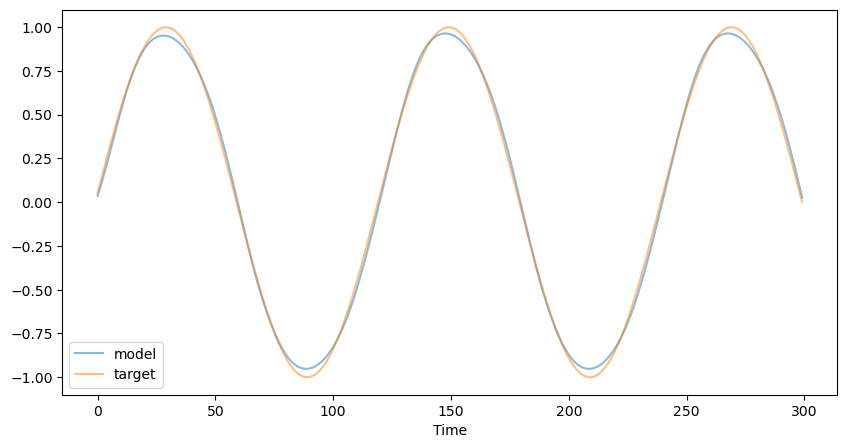

In [13]:
ndata = 300
time = ndata * timestep
time_points = np.arange(ndata).reshape(-1, 1)
inputs = np.sin(time_points/60*np.pi)
inputs = inputs.reshape(-1, 1)
outputs, activations = network.simulate(time, torch.tensor(inputs).float())

targets = np.sin((time_points+1)/60*np.pi)[0:300]
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs.detach().numpy(), alpha=0.5, label='model')
plt.plot(np.arange(len(targets)), targets, alpha=0.5, label='target')
plt.xlabel('Time')
plt.legend()
# plt.savefig("fig/1016_SIN_bpgain_output.png")

In [23]:
# params
theo_gain = np.ones((num_nodes, 1)) * 3
theo_shift = np.ones((num_nodes, 1))
hebbian_lr = 0.01
num_iters = 200
hebb_alpha_ext = 611
hebb_alpha_inh = 618

# record
losses = []
gain_changes = []
weight_sums = []

# start
for epoch in tqdm(range(num_iters)):

    # create RNN
    network = RNN(weight_matrix, connectivity_matrix, init_activation, theo_gain, theo_shift, input_weight_matrix, output_weight_matrix, 
                time_constant=time_constant, timestep=timestep)
    
    # backprop
    outputs, _ = network.simulate(time, torch.tensor(inputs).float())
    loss = nn.MSELoss()(outputs, torch.tensor(targets).float().reshape(-1, 1))

    # Calculate Hebbian weight updates
    activates_t = activations.T
    hebbian_update = torch.matmul(activates_t[:,0:-1], activates_t[:,1::].T)
    hebbian_update = hebbian_update * (network.weight_type * 2 - 1) * network.connectivity_matrix
    # Normalized Hebbian learning
    network.weight_matrix = network.weight_matrix + hebbian_lr * hebbian_update
    tmp_weights_ext = network.weight_matrix[network.weight_type]
    tmp_weights_inh = network.weight_matrix[~network.weight_type]
    network.weight_matrix[network.weight_type] = tmp_weights_ext / torch.sum(torch.abs(tmp_weights_ext)) * hebb_alpha_ext
    network.weight_matrix[~network.weight_type] = tmp_weights_inh / torch.sum(torch.abs(tmp_weights_inh)) * hebb_alpha_inh
    
    # update weight matrix
    weight_matrix = network.weight_matrix.detach().numpy()

    # record
    losses.append(loss.detach().item())
    weight_sums.append(np.sum(weight_matrix))

  0%|          | 0/200 [00:00<?, ?it/s]

Text(0, 0.5, 'Loss')

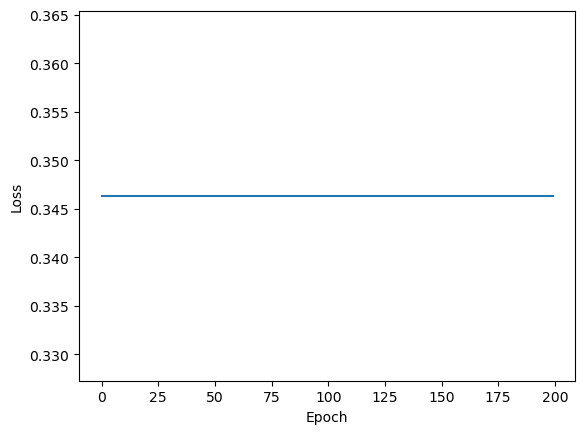

In [24]:
plt.plot(np.arange(len(losses)), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.ylim([0,0.5])
# plt.savefig("fig/1016_SIN_bpgain_loss.png")

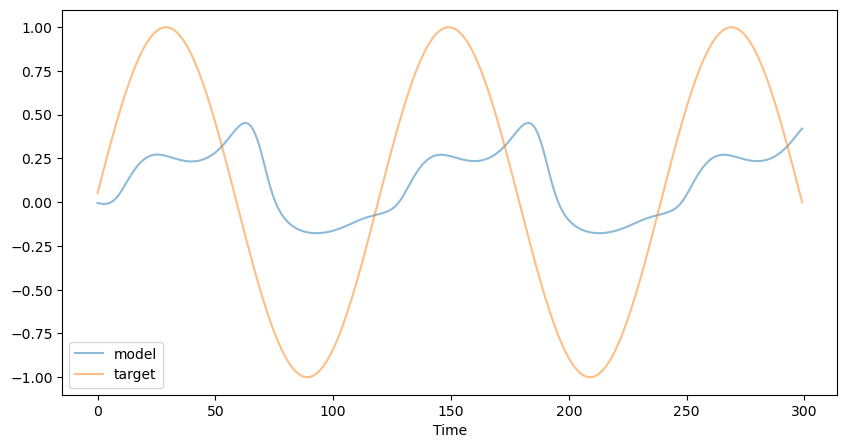

In [25]:
network = RNN(weight_matrix, connectivity_matrix, init_activation, theo_gain, theo_shift, input_weight_matrix, output_weight_matrix, 
            time_constant=time_constant, timestep=timestep)

ndata = 300
time_points = np.arange(ndata).reshape(-1, 1)
inputs = np.sin(time_points/60*np.pi)
inputs = inputs.reshape(-1, 1)
outputs, _ = network.simulate(time, torch.tensor(inputs).float())

targets = np.sin((time_points+1)/60*np.pi)[0:300]
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs.detach().numpy(), alpha=0.5, label='model')
plt.plot(np.arange(len(targets)), targets, alpha=0.5, label='target')
plt.xlabel('Time')
plt.legend()